In [20]:
import pandas as pd
import numpy as np
from datetime import datetime
import pycountry
from shapely.geometry import *
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest,f_classif,RFECV,SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,confusion_matrix

In [21]:
df=pd.read_csv('fraudTrain.csv')
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [22]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)

## Exploratory Data Analysis

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [24]:
df.isnull().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

Checking the distribution of target variable categories

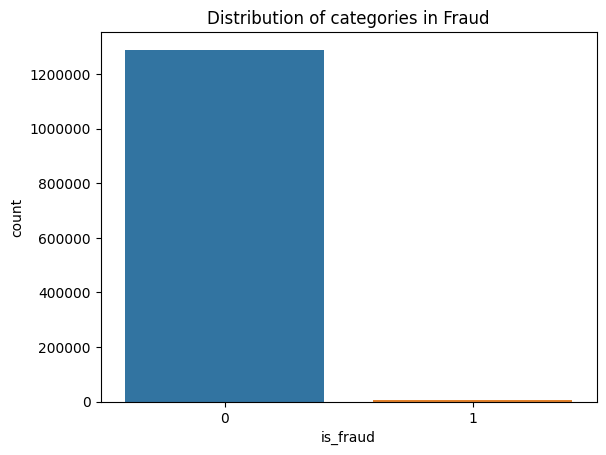

In [25]:
sns.countplot(data=df,x='is_fraud')
plt.ticklabel_format(style='plain',axis='y')
plt.title('Distribution of categories in Fraud')
plt.show()

As we can see there is a lot of variation in the category distribution. It is very common that very few transactions would be false transactions or frauds. Hence we need to sample the data to make the data look distributed normally.

In [26]:
t=df['trans_date_trans_time'][33001]
print(t)

2019-01-20 17:11:36


In [27]:
df['trans_date_trans_time']=df['trans_date_trans_time'].apply(lambda x: (datetime.strptime(x,r'%Y-%m-%d %H:%M:%S')))

In [28]:
df['year']=df['trans_date_trans_time'].apply(lambda x: x.year)
df['month']=df['trans_date_trans_time'].apply(lambda x: x.month)
df['day']=df['trans_date_trans_time'].apply(lambda x: x.strftime('%a'))
df['locale']=df['trans_date_trans_time'].apply(lambda x: x.strftime('%p'))
df['hour']=df['trans_date_trans_time'].apply(lambda x: x.strftime('%H'))
df['minute']=df['trans_date_trans_time'].apply(lambda x: x.strftime('%M'))

In [29]:
df.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,unix_time,merch_lat,merch_long,is_fraud,year,month,day,locale,hour,minute
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,1325376018,36.011293,-82.048315,0,2019,1,Tue,AM,00,00
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,1325376044,49.159047,-118.186462,0,2019,1,Tue,AM,00,00
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,1325376051,43.150704,-112.154481,0,2019,1,Tue,AM,00,00
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,1325376076,47.034331,-112.561071,0,2019,1,Tue,AM,00,01
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,1325376186,38.674999,-78.632459,0,2019,1,Tue,AM,00,03


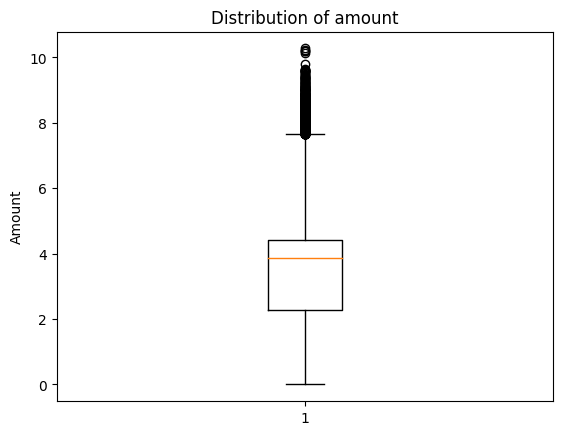

Whiskers: [array([2.26695792, 0.        ]), array([4.42052593, 7.65051134])]
Caps: [array([0., 0.]), array([7.65051134, 7.65051134])]
Medians: [array([3.86115068, 3.86115068])]
Boxes: [array([2.26695792, 2.26695792, 4.42052593, 4.42052593, 2.26695792])]


In [30]:
box=plt.boxplot(np.log(df['amt']))
plt.title('Distribution of amount')
plt.ylabel("Amount")
plt.show()
whiskers = [item.get_ydata() for item in box['whiskers']]
caps = [item.get_ydata() for item in box['caps']]
medians = [item.get_ydata() for item in box['medians']]
boxes = [item.get_ydata() for item in box['boxes']]

# Print the data
print('Whiskers:', whiskers)
print('Caps:', caps)
print('Medians:', medians)
print('Boxes:', boxes)

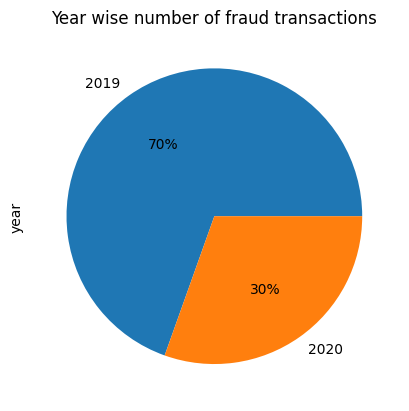

In [31]:
df.groupby('is_fraud')['year'].value_counts()[1].plot(y='Total number of frauds per year',kind='pie', autopct='%2.0f%%')
plt.title("Year wise number of fraud transactions")
plt.show()

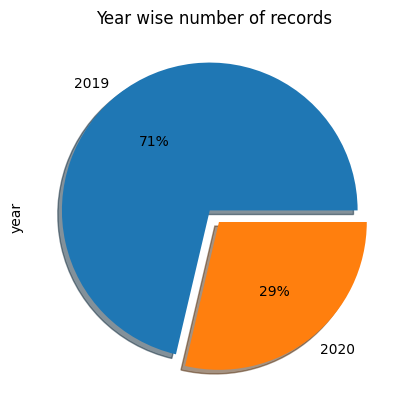

In [32]:
df.groupby('year')['year'].value_counts().plot(y='Total number of records per year',kind='pie', labels=['2019','2020'],autopct='%2.0f%%',explode=(0.05, 0.05), shadow=True)
plt.title("Year wise number of records")
plt.show()

As we can see there is a large difference in the distribution of data, so we can't say most of the frauds happened in 2020 from the previous pie chart.

In [33]:
print(df.groupby('year')['month'].min())
print(df.groupby('year')['month'].max())

year
2019    1
2020    1
Name: month, dtype: int64
year
2019    12
2020     6
Name: month, dtype: int64


As we can see that we have complete 1 year data of 2019 but not 2020. so the data could be biased more on the 2019 data.

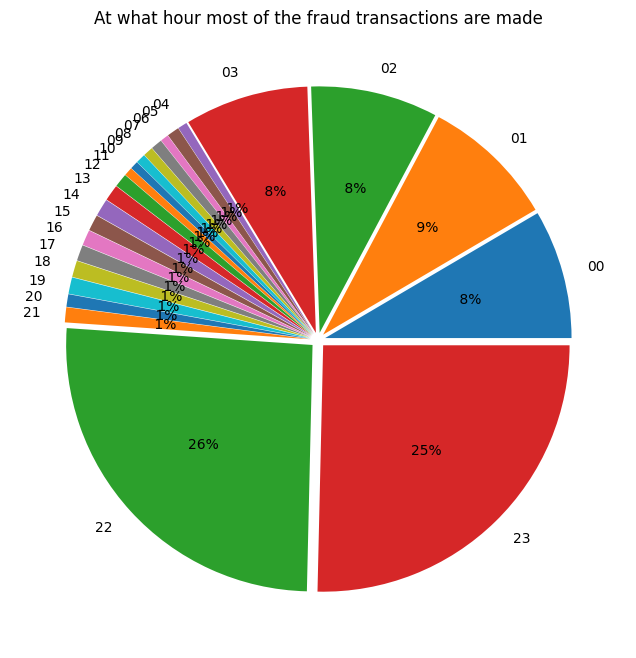

In [34]:
df[df['is_fraud']==1].groupby('hour')['hour'].value_counts().plot(kind='pie',autopct='%2.0f%%',labels=df['hour'].unique(),figsize=(8,8),explode=([0.03]*len(df['hour'].unique())))
plt.ylabel('')
plt.title('At what hour most of the fraud transactions are made')
plt.show()

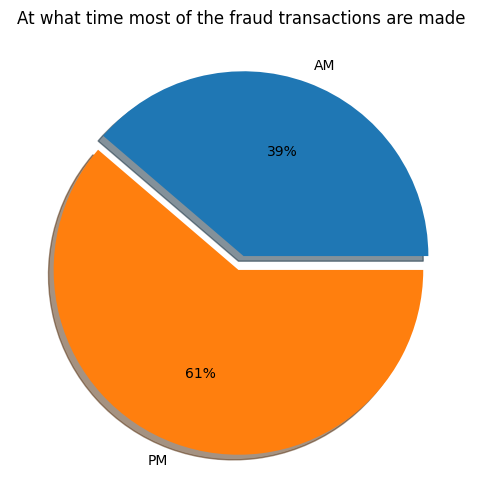

In [35]:
df[df['is_fraud']==1].groupby('locale')['locale'].value_counts().plot(kind='pie',autopct='%2.0f%%',labels=df['locale'].unique(),figsize=(6,6),explode=(0.04,0.04),shadow=True)
plt.ylabel('')
plt.title('At what time most of the fraud transactions are made')
plt.show()

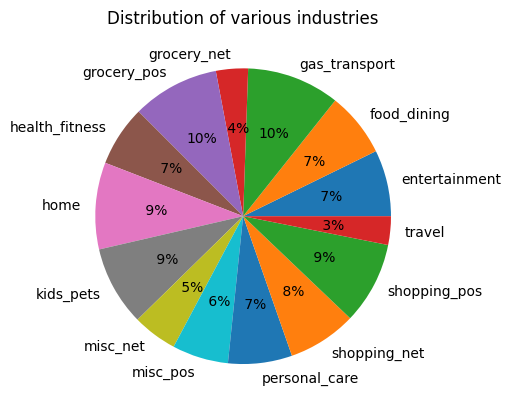

In [36]:
df.groupby('category').size().plot(kind='pie',autopct='%2.0f%%',y='Industries')
plt.title("Distribution of various industries")
plt.show()

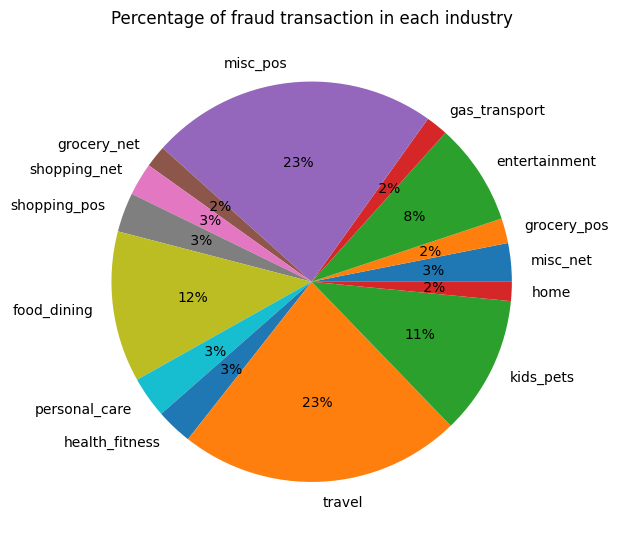

In [37]:
df[df['is_fraud']==1].groupby('category')['category'].count().plot(kind='pie',autopct='%2.0f%%',labels=df['category'].unique(),figsize=(6.5,6.5))
plt.ylabel('')
plt.title('Percentage of fraud transaction in each industry')
plt.show()

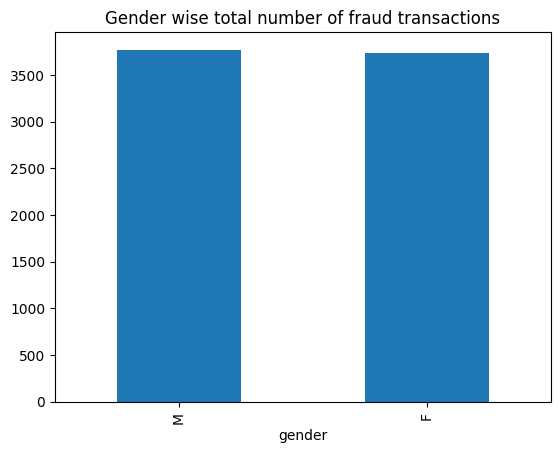

In [38]:
df.groupby('is_fraud')['gender'].value_counts()[1].plot(kind='bar')
plt.title('Gender wise total number of fraud transactions')
plt.show()

We can see that gender doesn't play any role in the total number of fraud transactions

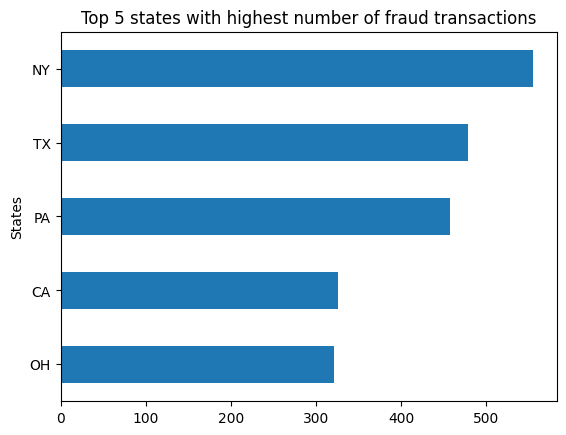

In [39]:
ax=(df[df['is_fraud']==1].groupby('state')['is_fraud'].value_counts().sort_values(ascending=False)[:5])[::-1].plot(kind='barh')
ax.set_yticklabels(reversed(['NY', 'TX', 'PA', 'CA', 'OH']))
plt.title('Top 5 states with highest number of fraud transactions')
plt.ylabel('States')
plt.show()

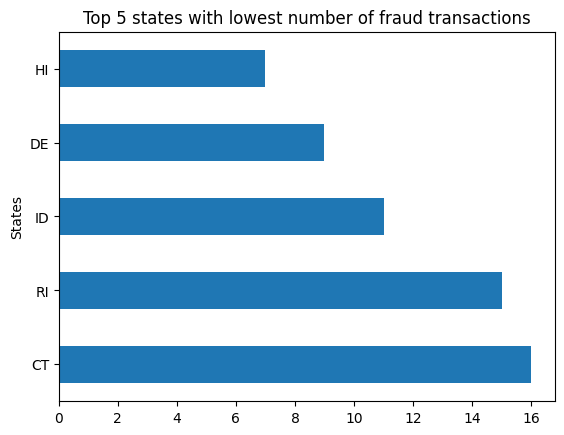

In [40]:
ax=(df[df['is_fraud']==1].groupby('state')['is_fraud'].value_counts().sort_values()[:5])[::-1].plot(kind='barh')
ax.set_yticklabels(reversed(['HI', 'DE', 'ID', 'RI', 'CT']))
plt.title("Top 5 states with lowest number of fraud transactions")
plt.ylabel("States")
plt.show()

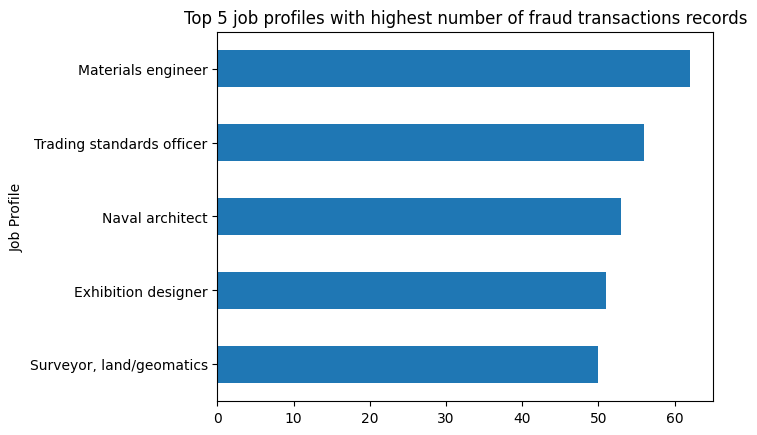

In [41]:
ax=(df[df['is_fraud']==1].groupby('job')['is_fraud'].value_counts().sort_values(ascending=False)[:5])[::-1].plot(kind='barh')
ax.set_yticklabels(reversed(['Materials engineer', 'Trading standards officer', 'Naval architect',
       'Exhibition designer', 'Surveyor, land/geomatics']))
plt.title("Top 5 job profiles with highest number of fraud transactions records")
plt.ylabel("Job Profile")
plt.show()

In [42]:
world_map=gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [43]:
def map_country_name(short_name):
    try:
        return pycountry.countries.get(alpha_2=short_name).name
    except:
        return None

df['country'] = df['state'].apply(map_country_name)

In [44]:
df = df.dropna(subset=['country'])

Text(0.5, 1.0, 'Fraud Transactions grouped  by country')

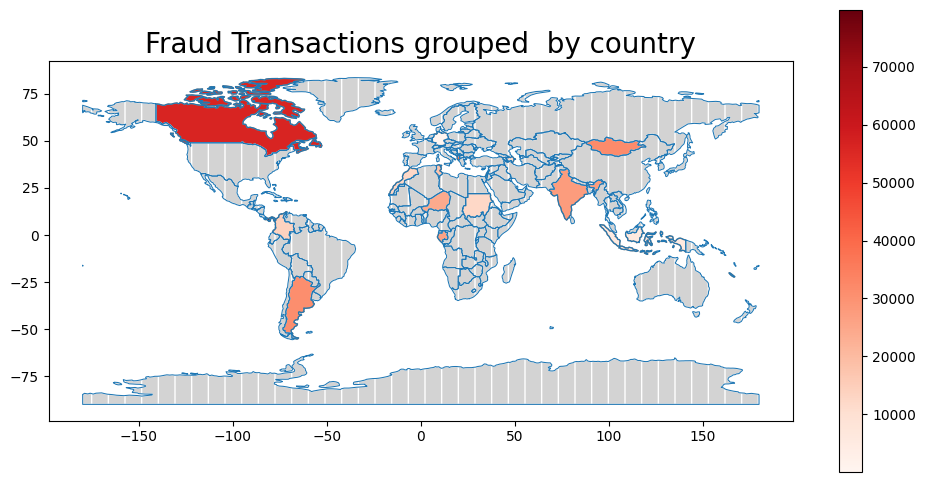

In [45]:
count_by_country = df.groupby('country').size().reset_index(name='count')
merged = world_map.merge(count_by_country, left_on='name', right_on='country',how='left')
world_copy = world_map.copy()
world_copy.loc[~world_copy['name'].isin(merged['name']), 'geometry'] = None
ax = world_copy["geometry"].boundary.plot(figsize=(12, 6), facecolor='none', linewidth=0.75)
merged.plot(column='count', cmap='Reds',  edgecolor='grey', legend=True, ax=ax, missing_kwds={'color': 'lightgrey', "edgecolor": "white", "hatch": "|"})
ax.set_title('Fraud Transactions grouped  by country', fontdict={'fontsize': 20})

In [46]:
def get_card_type(card_number):
    # Remove any whitespace or hyphens from the card number
    card_number = str(card_number).replace(" ", "").replace("-", "")
    
    # Check the first few digits to identify the card type
    if card_number.startswith("4"):
        return "Visa"
    elif card_number.startswith(("51", "52", "53", "54", "55")):
        return "Mastercard"
    elif card_number.startswith(("34", "37")):
        return "American Express"
    elif card_number.startswith("6011") or card_number.startswith(("65")):
        return "Discover"
    elif card_number.startswith(("3528", "3529", "353", "354", "355", "356", "357", "358", "359")):
        return "JCB"
    else:
        return "Unknown"


In [47]:
df['card_type']=df['cc_num'].apply(lambda x: get_card_type(x))

In [48]:
df['card_type'].value_counts()

Visa                230362
Unknown             223269
JCB                  93225
Discover             64188
American Express     62351
Mastercard           12352
Name: card_type, dtype: int64

In [49]:
df[df['is_fraud']==1].groupby('card_type')['card_type'].value_counts()

card_type         card_type       
American Express  American Express     325
Discover          Discover             386
JCB               JCB                  603
Mastercard        Mastercard            78
Unknown           Unknown             1183
Visa              Visa                1361
Name: card_type, dtype: int64

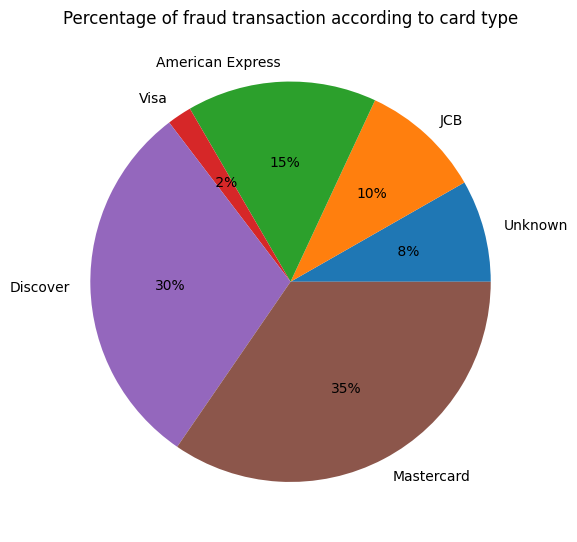

In [50]:
df[df['is_fraud']==1].groupby('card_type')['card_type'].count().plot(kind='pie',autopct='%2.0f%%',labels=df['card_type'].unique(),figsize=(6.5,6.5))
plt.ylabel('')
plt.title('Percentage of fraud transaction according to card type')
plt.show()

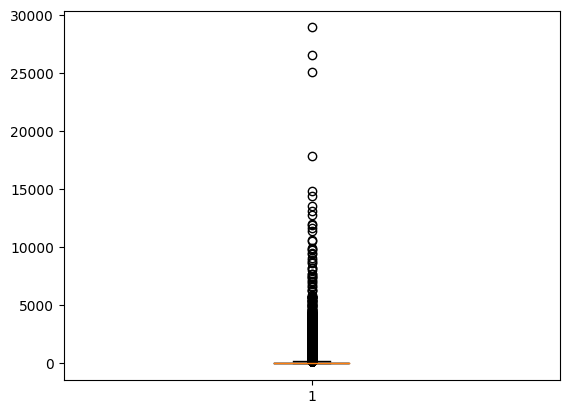

In [51]:
plt.boxplot(df['amt'])
plt.show()

In [52]:
df=df[df['amt']<175]

In [53]:
df.groupby('is_fraud')['is_fraud'].count()

is_fraud
0    642608
1       949
Name: is_fraud, dtype: int64

## Feautre Engineering

Log transformation of amount

In [54]:
# df['amt']=np.log(df['amt'])

labeling the categorical features

In [55]:
categorical=[feature for feature in df.columns if df[feature].dtypes=='O' and feature not in ['first', 'last','street','dob', 'state', 'trans_num','hour', 'minute',]]
print(categorical)

['merchant', 'category', 'gender', 'city', 'job', 'day', 'locale', 'country', 'card_type']


In [56]:
merchant_encoder=LabelEncoder()
df['merchant']=merchant_encoder.fit_transform(df['merchant'])
category_encoder=LabelEncoder()
df['category']=merchant_encoder.fit_transform(df['category'])
gender_encoder=LabelEncoder()
df['gender']=merchant_encoder.fit_transform(df['gender'])
city_encoder=LabelEncoder()
df['city']=merchant_encoder.fit_transform(df['city'])
job_encoder=LabelEncoder()
df['job']=merchant_encoder.fit_transform(df['job'])
day_encoder=LabelEncoder()
df['day']=merchant_encoder.fit_transform(df['day'])
locale_encoder=LabelEncoder()
df['locale']=merchant_encoder.fit_transform(df['locale'])
country_encoder=LabelEncoder()
df['country']=merchant_encoder.fit_transform(df['country'])
card_type_encoder=LabelEncoder()
df['card_type']=merchant_encoder.fit_transform(df['card_type'])

In [57]:
df['minute']=df['minute'].astype(int)
df['hour']=df['hour'].astype(int)

In [58]:
df.drop(['trans_date_trans_time','first','last','state','street','dob','trans_num','unix_time'],axis=1,inplace=True)

Sampling imbalanced data

In [59]:
x=df.drop(['is_fraud'],axis=1)
y=df['is_fraud']

In [60]:
scale=StandardScaler()
x=scale.fit_transform(x)

In [61]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [62]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

## Feature Selection

Univariate feature selection using SelectKBest

In [64]:
selector = SelectKBest(f_classif, k=5)
X_new = selector.fit_transform(X_train_resampled, y_train_resampled)
print('Selected feature indices:', df.drop(['is_fraud'],axis=1).columns[selector.get_support(indices=True)])

Selected feature indices: Index(['category', 'amt', 'gender', 'month', 'locale'], dtype='object')


Feature selection using tree-based models with SelectFromModel:

In [67]:
estimator = RandomForestClassifier()
selector = SelectFromModel(estimator)
selector.fit(X_train_resampled, y_train_resampled)
print('Selected feature indices:', df.drop(['is_fraud'],axis=1).columns[selector.get_support(indices=True)])

Selected feature indices: Index(['category', 'amt', 'hour'], dtype='object')


Correlation-based feature selection:

In [66]:
correlation_scores, p_values = f_classif(X_train_resampled, y_train_resampled)
correlation_df = pd.DataFrame({'Feature': df.drop(['is_fraud'],axis=1).columns, 'Correlation_Score': correlation_scores, 'P-Value': p_values})
correlation_df = correlation_df.sort_values(by=['Correlation_Score'], ascending=False)
k = 5
top_k_features = list(correlation_df['Feature'][:k])
X_top_k = df.drop(['is_fraud'],axis=1)[top_k_features]
print("Top {} Features: {}".format(k,top_k_features))

Top 5 Features: ['amt', 'month', 'category', 'locale', 'gender']


Recursive feature elimination with cross-validation (RFECV):

In [ ]:
# estimator = LogisticRegression()
# selector = RFECV(estimator, cv=10)
# selector.fit(X_train_resampled, y_train_resampled)
# print('Selected feature indices:', X_train_resampled.columns[selector.get_support(indices=True)])

Selected feature indices: Index(['cc_num'], dtype='object')


In [68]:
features=['category', 'amt', 'locale', 'hour']
features.extend(['amt', 'month', 'category', 'locale', 'gender'])
features.extend(['category', 'amt', 'hour'])
count = pd.Series(features).value_counts()
print(count)

category    3
amt         3
locale      2
hour        2
month       1
gender      1
dtype: int64


In [69]:
final_features=['category','amt','locale','hour']

In [72]:
X_train_resampled=pd.DataFrame(X_train_resampled,columns=df.drop(['is_fraud'],axis=1).columns)
x_test=pd.DataFrame(x_test,columns=df.drop(['is_fraud'],axis=1).columns)
X_train=X_train_resampled[final_features]
X_test=x_test[final_features]

## Model Training

### Logistic Regression

In [73]:
logistic_model=LogisticRegression()
logistic_model.fit(X_train,y_train_resampled)
lg_predictions=logistic_model.predict(X_test)
lg_scores=logistic_model.predict_proba(X_test)
print(classification_report(y_test,lg_predictions,zero_division =1))
print(confusion_matrix(y_test,lg_predictions))

              precision    recall  f1-score   support

           0       1.00      0.65      0.79    128522
           1       0.00      0.81      0.01       190

    accuracy                           0.65    128712
   macro avg       0.50      0.73      0.40    128712
weighted avg       1.00      0.65      0.79    128712

[[83968 44554]
 [   37   153]]


AUC Score:- 0.7292993867934958


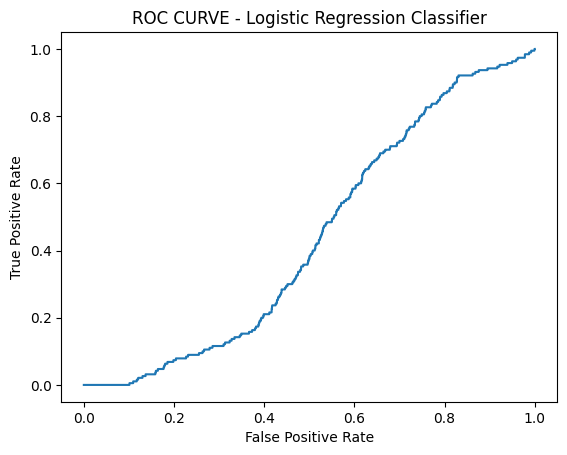

In [74]:
scores=[]
for lg_score in lg_scores:
    scores.append(max(lg_score))

fpr,tpr,thresholds=roc_curve(y_test,scores)
print(f"AUC Score:- {roc_auc_score(y_test,lg_predictions)}")
plt.plot(fpr,tpr)
plt.title("ROC CURVE - Logistic Regression Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Decision tree classifier

In [75]:

dt_model=DecisionTreeClassifier()
dt_model.fit(X_train,y_train_resampled)
dt_predictions=dt_model.predict(X_test)
dt_scores=dt_model.predict_proba(X_test)
print(classification_report(y_test,dt_predictions))
print(confusion_matrix(y_test,dt_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    128522
           1       0.13      0.64      0.21       190

    accuracy                           0.99    128712
   macro avg       0.56      0.82      0.60    128712
weighted avg       1.00      0.99      1.00    128712

[[127681    841]
 [    69    121]]


AUC Score:- 0.8151492392455438


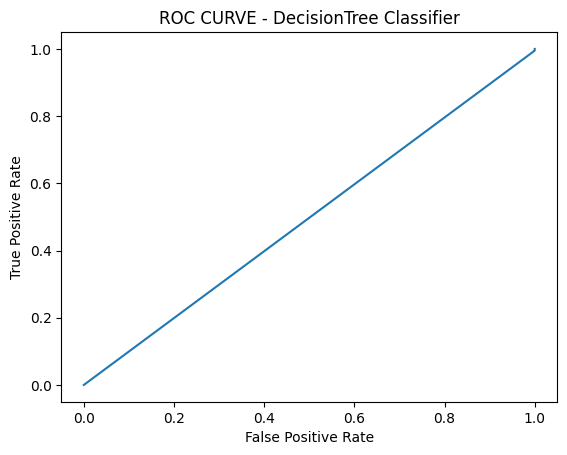

In [76]:
scores=[]
for dt_score in dt_scores:
    scores.append(max(dt_score))

fpr,tpr,thresholds=roc_curve(y_test,scores)
print(f"AUC Score:- {roc_auc_score(y_test,dt_predictions)}")
plt.plot(fpr,tpr)
plt.title("ROC CURVE - DecisionTree Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Randomforest Classifier

In [77]:
rf_model=RandomForestClassifier()
rf_model.fit(X_train,y_train_resampled)
rf_predictions=rf_model.predict(X_test)
rf_scores=rf_model.predict_proba(X_test)
print(classification_report(y_test,rf_predictions))
print(confusion_matrix(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00    128522
           1       0.13      0.65      0.21       190

    accuracy                           0.99    128712
   macro avg       0.56      0.82      0.60    128712
weighted avg       1.00      0.99      1.00    128712

[[127677    845]
 [    67    123]]


AUC Score:- 0.8203968356021784


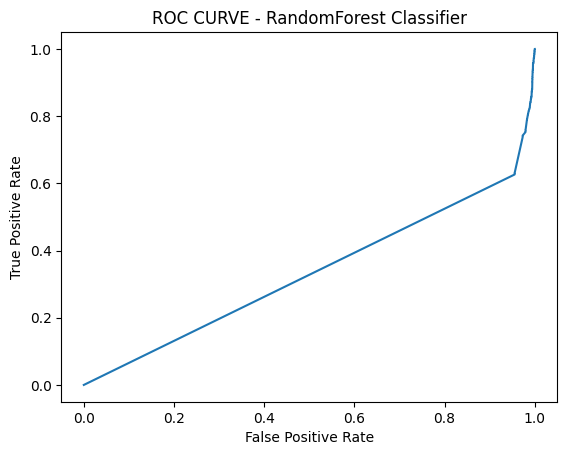

In [78]:
scores=[]
for rf_score in rf_scores:
    scores.append(max(rf_score))

fpr,tpr,thresholds=roc_curve(y_test,scores)
print(f"AUC Score:- {roc_auc_score(y_test,rf_predictions)}")
plt.plot(fpr,tpr)
plt.title("ROC CURVE - RandomForest Classifier")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()